In [1]:
import cv2
import imutils
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from deskew import determine_skew
import face_recognition
import time

In [2]:
def traditional_processing(image,kw,kh):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kw, kh))
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    gray = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    gray = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(gray)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.threshold(grad, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.dilate(thresh, None, iterations=3)
    return thresh

In [20]:
def extract_clips(image,kw,kh,grp_id):
    original = image.copy()
    image = traditional_processing(image,kw,kh)
    im_h,im_w = image.shape[:2]
    cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    exp_id = 0
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        (xstart,ystart,xend,yend)=(x,y,x+w,y+h)
        clip = original[ystart:yend,xstart:xend]
        if(x*h>4000 and w>h):
            cv2.imwrite("datasets/barcode_dir/"+"eee"+str(grp_id)+str(exp_id)+".jpg",clip)
            exp_id+=1

In [14]:
def face_detect_rotate(image):
    trials = 0
    while(trials<4):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        face_locations = face_recognition.face_locations(gray)
        if(len(face_locations)>0):
            main_face = max(face_locations,key = lambda x : abs(x[0] - x[2]) * abs(x[1] - x[3]))
            leftX = main_face[1]
            return (leftX,image)
        else : 
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE) 
            trials += 1
    return 0

In [15]:
def show(image):
    fig = plt.figure(figsize=(10, 10))
    rows = 1
    columns = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(image)
    plt.title("image")
    plt.axis('off')

In [16]:
relative_path = "../Docs/dataset"
passport_list = os.listdir(relative_path)
passport_list = [p for p in passport_list if p[-4:]==".jpg"]

In [21]:
grp_id = 0
for passport in passport_list:
    image = cv2.imread(os.path.join(relative_path,passport))
    res = face_detect_rotate(image)
    try:
        _,rotated = res
        image = rotated
        (h,w) = image.shape[:2]
        area = (h*w)
        while(area < 900*1500):
            image = cv2.resize(image, ( int(w*1.4), int(h*1.4) ), interpolation = cv2.INTER_AREA)
            (h,w) = image.shape[:2]
            area = (h*w)
        extract_clips(image,40,8,grp_id)
    except Exception as e: 
        print("face not found",e)
    grp_id += 1
    print( str( int (grp_id / len(passport_list) * 100) )+ "%" ,end="=> ")
print("completed")

2%=> 4%=> 6%=> 8%=> 10%=> face not found cannot unpack non-iterable int object
13%=> 15%=> 17%=> face not found cannot unpack non-iterable int object
19%=> 21%=> 23%=> 26%=> 28%=> 30%=> 32%=> 34%=> 36%=> face not found cannot unpack non-iterable int object
39%=> 41%=> 43%=> 45%=> 47%=> 50%=> 52%=> 54%=> 56%=> 58%=> 60%=> 63%=> 65%=> 67%=> 69%=> 71%=> 73%=> 76%=> 78%=> 80%=> 82%=> 84%=> 86%=> 89%=> 91%=> 93%=> 95%=> 97%=> 100%=> completed


In [67]:
dirc = "datasets/barcode_dir/"
bar_dir = "datasets/barcode_dir/bar/"
nobar_dir = "datasets/barcode_dir/no_bar/"
bars = os.listdir(bar_dir)
nobars = os.listdir(nobar_dir)
dircf = os.listdir(dirc) 
print(len(bars))
print(len(nobars))
print(len(dircf))

725
951
2


In [15]:
for nobar in nobars:
    image = cv2.imread(nobar_dir+nobar)
    (h,w) = image.shape[:2]
    if 50 > w :
        os.remove(nobar_dir+nobar)

In [32]:
for bar in bars:
    image = cv2.imread(bar_dir+bar)
    rotated90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    fliped = cv2.rotate(rotated90, cv2.ROTATE_90_CLOCKWISE) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    zeros = np.zeros(gray.shape)
    rgb = cv2.merge([gray,gray,gray])
    cv2.imwrite(bar_dir+"flip"+bar,fliped)
    cv2.imwrite(bar_dir+"gray"+bar,rgb)
    cv2.imwrite(bar_dir+"half1"+bar,image[:,0:int(image.shape[1]/2)])
    cv2.imwrite(bar_dir+"half2"+bar,image[:,int(image.shape[1]/2):image.shape[1]])

In [34]:
for bar in dircf:
    try:
        image = cv2.imread(dirc+bar)
        rotated90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        fliped = cv2.rotate(rotated90, cv2.ROTATE_90_CLOCKWISE) 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        zeros = np.zeros(gray.shape)
        rgb = cv2.merge([gray,gray,gray])
        cv2.imwrite(dirc+"flip"+bar,fliped)
        cv2.imwrite(dirc+"gray"+bar,rgb)
        cv2.imwrite(dirc+"half1"+bar,image[:,0:int(image.shape[1]/2)])
        cv2.imwrite(dirc+"half2"+bar,image[:,int(image.shape[1]/2):image.shape[1]])
    except Exception as e:
        print("not an image",e)

not an image OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

not an image OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



In [12]:
bars = [s for s in bars if "Copy" in s]

In [42]:
print(len(bars))

725


In [14]:
for bar in bars:
    os.remove(bar_dir+bar)

In [16]:
378/6

63.0

In [68]:
records = []
for bar in bars : 
    image = cv2.imread(bar_dir+bar)
    h,w = image.shape[:2]
    records.append((h,w,h/w,0))
    
for nobar in nobars : 
    image = cv2.imread(nobar_dir+nobar)
    h,w = image.shape[:2]
    records.append((h,w,h/w,1))
df = pd.DataFrame(records)
df.describe()

,0,1,2,3
count,1676.0,1676.0,1.676000e+03,1676.000000
mean,70.0,400.0,1.750000e-01,0.567422
std,0.0,0.0,5.552772e-15,0.495581
min,70.0,400.0,1.750000e-01,0.000000
25%,70.0,400.0,1.750000e-01,0.000000
50%,70.0,400.0,1.750000e-01,1.000000
75%,70.0,400.0,1.750000e-01,1.000000
max,70.0,400.0,1.750000e-01,1.000000


In [69]:
bars = df.loc[df[3] == 0]
bars.describe()

,0,1,2,3
count,725.0,725.0,7.250000e+02,725.0
mean,70.0,400.0,1.750000e-01,0.0
std,0.0,0.0,1.999781e-15,0.0
min,70.0,400.0,1.750000e-01,0.0
25%,70.0,400.0,1.750000e-01,0.0
50%,70.0,400.0,1.750000e-01,0.0
75%,70.0,400.0,1.750000e-01,0.0
max,70.0,400.0,1.750000e-01,0.0


62     74
53     16
65     16
66     14
58     13
       ..
343     1
319     1
21      1
469     1
277     1
Name: 1, Length: 342, dtype: int64


<BarContainer object of 342 artists>

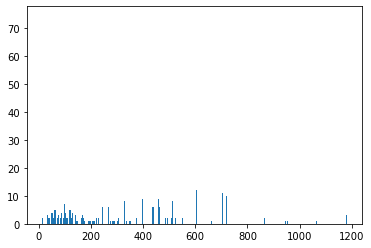

In [51]:
idxs = df[1].unique()

values = df[1].value_counts()
print(values)
plt.bar(idxs,values)

In [56]:
bars[:5]

['bar/03.jpg', 'bar/10.jpg', 'bar/102.jpg', 'bar/110.jpg', 'bar/128.jpg']

In [50]:
target_shape = (300,70)
bars = ["bar/"+b for b in bars]
nobars = ["no_bar/"+b for b in nobars]
paths = bars + nobars
print(len(paths))

1676


In [51]:
paths = [p for p in paths if p[-4:]==".jpg"]
print(len(paths))

1676


In [65]:
for path in paths:
        path = os.path.join("datasets/barcode_dir",path)
        image = cv2.imread(path)
        resized = cv2.resize(image, (400,70), interpolation = cv2.INTER_AREA)
        os.remove(path)
        cv2.imwrite(path,resized)

<BarContainer object of 9 artists>

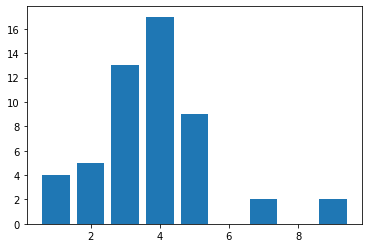

In [4]:
import matplotlib.pyplot as plt
indx = [1,2,3,4,5,6,7,8,9]
values = [4,5,13,17,9,0,2,0,2]
plt.bar(indx,values)

In [10]:
import pandas as pd
df = pd.DataFrame([[278, 33, 8.43, "bar/10.jpg",1],
                   [502, 70, 7.17, "bar/55.jpg",1],
                   [366, 40, 9.15, "bar/105.jpg",1],
                   [470, 71, 6.71, "bar/188.jpg",1],
                   [423, 35, 12.34, "bar/237.jpg",1],
                ])

In [12]:
df["width"] = df[0]
df["height"] = df[1]
df["ratio"] = df[2]
df["path"] = df[3]
df["class"] = df[4]

In [15]:
df.drop([0,1,2,3,4],axis=1)

,width,height,ratio,path,class
0,278,33,8.43,bar/10.jpg,1
1,502,70,7.17,bar/55.jpg,1
2,366,40,9.15,bar/105.jpg,1
3,470,71,6.71,bar/188.jpg,1
4,423,35,12.34,bar/237.jpg,1


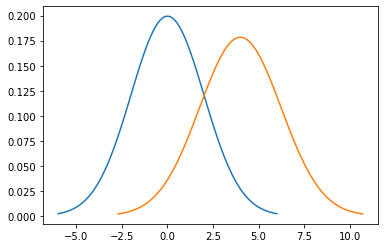

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 4
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
mu = 4
variance = 5
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()